In [4]:
import numpy as np
from numba import njit
from time import time
import benchit

Bolt komandoje dirba duomenų analitikai, kurie gali prisijungti prie serverio ir naudodami duomenų bazių užklausas peržiūrėti visas kiekvieno kurjerio kiekvienos dienos uždirbtas sumas. Vienoje iš duomenų bazių yra saugomi kurjerio unikalūs ID ir uždirbtos pinigų sumos skirtingomis dienomis: 
    
    X = np.array([[ 68,  62],
                  [ 69,  28],
                  [ 69,  72],
                  [ 69,  85],
                  [ 72,   9],
                  [ 70,   7],
                  [ 70,  67],
                  [ 71,  77],
                  [ 67,  68],
                  [ 69,  50],
                  [ 71,  56],
                  [ 68,  84],
                  [ 67,  42],
                  [ 69,  46],
                  [ 68, 127],
                  [ 67, 104],
                  [ 70,  63],
                  [ 72,  61],
                  [ 69,  63],
                  [ 68,  35]])
                   
Bolt nusprendė į programėlę įdiegti naujovę: galimybę peržiūrėti kiekvienam kurjeriui diagramą, kur uždarbiai būtų surikiuoti didėjimo tvarka. Raskite kiekvieno kurjerio visas uždirbtas sumas, surikiuotas didėjimo tvarka.

### Input

    N = 20
    x1 = np.random.randint(0, 10, size=N)
    x2 = np.random.normal(loc=67, scale=73, size=N).astype(int)
    X = np.transpose([x1, x2])

or:

    array([[ 68,  62],
           [ 69,  28],
           [ 69,  72],
           [ 69,  85],
           [ 72,   9],
           [ 70,   7],
           [ 70,  67],
           [ 71,  77],
           [ 67,  68],
           [ 69,  50],
           [ 71,  56],
           [ 68,  84],
           [ 67,  42],
           [ 69,  46],
           [ 68, 127],
           [ 67, 104],
           [ 70,  63],
           [ 72,  61],
           [ 69,  63],
           [ 68,  35]])
                   
### Expected output

     {67: array([ 42,  68, 104]),
      68: array([ 35,  62,  84, 127]),
      69: array([28, 46, 50, 63, 72, 85]),
      70: array([ 7, 63, 67]),
      71: array([56, 77]),
      72: array([ 9, 61])}

## Solutions

In [1]:
def _custom_return(unique_id, a, split_idx, return_groups):
    if return_groups:
        return unique_id, np.split(a[:,1], split_idx)
    else: 
        return np.split(a[:,1], split_idx)

### Solution 1: use `numpy.lexsort`

In [6]:
def numpy_lexsort(arr, return_groups=True):
    arr = arr[np.lexsort([arr[:,1], arr[:,0]])] #lexsort
    idx = np.flatnonzero(np.diff(arr[:,0])) + 1 #find splitting idx
    return _custom_return(arr[np.insert(idx, 0, 0), 0], arr, idx, return_groups)

dict(zip(*numpy_lexsort(X)))

{67: array([ 42,  68, 104]),
 68: array([ 35,  62,  84, 127]),
 69: array([28, 46, 50, 63, 72, 85]),
 70: array([ 7, 63, 67]),
 71: array([56, 77]),
 72: array([ 9, 61])}

### Solution 2: use dimensionality reduction then `numpy.argsort`

In [9]:
@njit
def __numba_dot(arr, dim_shapes, len_arr, len_dim_shapes, su):
    for i in range(len_arr):
        for j in range(len_dim_shapes):
            su[i] += arr[i][j] * dim_shapes[j]
        
def _numba_dimreduce(arr, dtype=np.int32):
    '''not safe if allocation is exceeded'''
    M = np.max(arr, axis=0)
    limit = np.array(M[:-1] + 1, dtype=dtype)
    dim_shapes = np.cumprod(np.insert(limit, 0, 1))
    su = np.zeros(len(arr), dtype=dtype)
    _numba_dot(arr, dim_shapes, len(arr), len(dim_shapes), su)
    return su

_numba_dimreduce(X)

array([4594, 2113, 5325, 6274,  729,  581, 4961, 5692, 5031, 3719, 4159,
       6200, 3133, 3427, 9339, 7659, 4669, 4525, 4668, 2623])

In [11]:
def dimreduce_sort(arr, return_groups=True):
    arr_hash = _numba_dimreduce(arr[:,::-1].copy(), dtype=int)
    arr = arr[np.argsort(arr_hash)]
    idx = np.flatnonzero(np.diff(arr[:,0])) + 1 #find splitting idx
    return _custom_return(arr[np.insert(idx, 0, 0), 0], arr, idx, return_groups)
dict(zip(*dimreduce_sort(X)))

{67: array([ 42,  68, 104]),
 68: array([ 35,  62,  84, 127]),
 69: array([28, 46, 50, 63, 72, 85]),
 70: array([ 7, 63, 67]),
 71: array([56, 77]),
 72: array([ 9, 61])}

### Solution 3: use optimised groupby on column 1 then sort values of each group

In [12]:
@njit
def __numba_bincount(a, counts, m):
    for i in range(m):
        counts[a[i]] += 1

def _numba_bincount(arr): #just a refactor of numpy bincount
    M = np.max(arr)
    counts = np.zeros(M + 1, dtype=int)
    __numba_bincount(arr, counts, len(arr))
    return counts

def _numba_groupby_bins(a, return_groups=False):  
    bins = _numba_bincount(a[:,0])
    nonzero_bins_idx = bins != 0
    nonzero_bins = bins[nonzero_bins_idx]
    idx = np.cumsum(nonzero_bins[:-1])
    return _custom_return(np.flatnonzero(nonzero_bins_idx), a, idx, return_groups)

print(_numba_bincount(np.array([2,3,2,1,5,5,5,2])))
print(_numba_groupby_bins(X[X[:, 0].argsort()], return_groups=True))

[0 1 3 1 0 3]
(array([67, 68, 69, 70, 71, 72], dtype=int64), [array([104,  42,  68]), array([ 62, 127,  84,  35]), array([63, 85, 46, 72, 28, 50]), array([ 7, 63, 67]), array([77, 56]), array([ 9, 61])])


In [13]:
def group_sort(X, return_groups=True):
    a = X[X[:, 0].argsort()]
    keys, vals = _numba_groupby_bins(a, return_groups=True)
    if return_groups:
        return keys, list(map(np.sort, vals))
    else:
        return list(map(np.sort, vals))
    
dict(zip(*group_sort(X)))

{67: array([ 42,  68, 104]),
 68: array([ 35,  62,  84, 127]),
 69: array([28, 46, 50, 63, 72, 85]),
 70: array([ 7, 63, 67]),
 71: array([56, 77]),
 72: array([ 9, 61])}

### Timinigs
Note that groupby is the fastest in case the number of groups is small

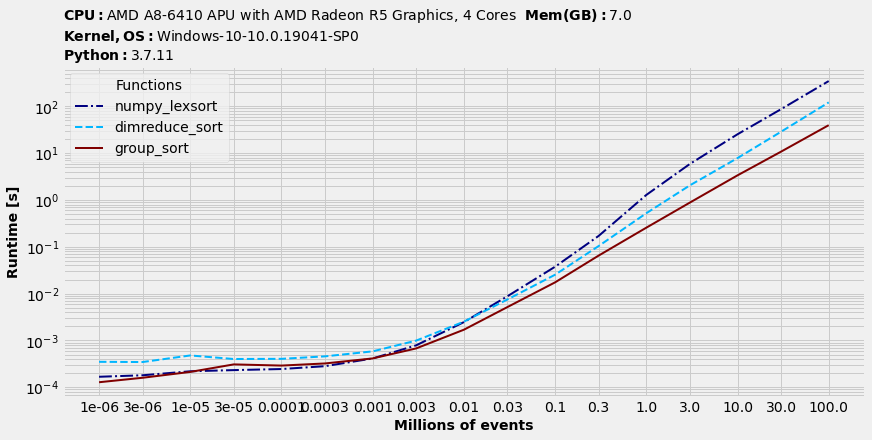

In [13]:
%matplotlib inline
benchit.setparams(rep=1)

sizes = [3*10**(i//2) if i%2 else 10**(i//2) for i in range(17)]
N = sizes[-1]
x1 = np.random.randint(0,10, size=N)
x2 = np.random.normal(loc=500, scale=200, size=N).astype(int)
arr = np.transpose([x1, x2])

fns = [numpy_lexsort, dimreduce_sort, group_sort]
in_ = {s/1000000: (arr[:s], ) for s in sizes}
t = benchit.timings(fns, in_, multivar=True, input_name='Millions of events')
t.plot(logx=True, figsize=(12, 6), fontsize=14)